# Elements


Shape functions are generally chosen to approximate the (unknown) function *on each element* in terms of the weights discussed above, which are generally called the *degrees of freedom* (DOFs).

The choice of *element type* determines:
* the function which approximates the solution on the element.
* the *nodes* - the points within the element at which the degrees of freedom are specified.
* the meaning of the DOFs which might be:
* * function value
* * gradient
* * divergence of a vector field
* the continuity of the approximate solution between elements.
* integration scheme (typically in terms of the Gauss Points).

One might consider placing DOFs at the Gauss Points to expedite integration, but this is not common. It is more important for the the shape functions should reflect the behaviour of the solution (e.g.: continuity, conservation of divergence, high order variations.


#### Lagrange elements

A general purpose basis is our good old Lagrange interpolation functions! These functions have nodes at the verticies of the mesh (at least), at which the value of the function is specified. Higher order elements (i.e. higher order polynomials) include additional nodes *inside* the element.

LaGrange shape functions are 1 at the associated node and 0 at *every* other node.    

$$\phi_i(x_j) = \delta_{ij}$$

The first three orders (in 1D) are:


| **Order** | **Node** ................   | **Basis Function**..................................................                                   |
|-----------|-----------------------|------------------------------------------------------|
| 0    | $x_0 = 0$             | $\phi_0(x) = 1$                                      |
| 1     | $x_0 = 0$             | $\phi_0(x) = 1 - x$                                  |
|           | $x_1 = 1$             | $\phi_1(x) = x$                                      |
| 2    | $x_0 = 0$             | $\phi_0(x) = 2(1 - x)(0.5 - x)$                      |
|           | $x_1 = 0.5$           | $\phi_1(x) = 4x(1 - x)$                              |
|           | $x_2 = 1$             | $\phi_2(x) = 2x(x - 0.5)$                            |
| 3     | $x_0 = 0$             | $\phi_0(x) = -9/2 (x - 1/3)(x - 2/3)(x - 1)$         |
|           | $x_1 = 1/3$           | $\phi_1(x) = 27/2 x(x - 2/3)(x - 1)$                 |
|           | $x_2 = 2/3$           | $\phi_2(x) = -27/2 x(x - 1/3)(x - 1)$                |
|           | $x_3 = 1$             | $\phi_3(x) = 9/2 x(x - 1/3)(x - 2/3)$                |

as plotted below.

In [41]:
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

import matplotlib.pyplot as plt

# Define Lagrange basis functions for each order
def lagrange_basis(order, x, node):
    """
    Compute the Lagrange basis function for a given node and order.

    Args:
    - order: Order of the Lagrange polynomial (0, 1, 2, 3).
    - x: The points where the function is evaluated (numpy array).
    - node: The index of the current basis function (0, 1, ..., order).

    Returns:
    - The values of the Lagrange basis function at points `x`.
    """
    if order ==0:
      nodes = .5
    else:
      nodes = np.linspace(0, 1, order + 1)
    basis = np.ones_like(x)
    for j in range(order + 1):
        if j != node:
            basis *= (x - nodes[j]) / (nodes[node] - nodes[j])
    return basis

# Function to plot the Lagrange basis functions
def plot_lagrange_basis(order):
    x = np.linspace(0, 1, 500)  # Points to evaluate the basis functions
    colors = ['blue', 'green', 'orange', 'red']  # Colors for each order
    plt.figure(figsize=(10, 8))
    if order ==0:
      nodes = np.array([.5])
    else:
      nodes = np.linspace(0, 1, order + 1)
    for node in range(order + 1):
        y = lagrange_basis(order, x, node)
        plt.plot(x, y, label=f"Node {node}")
        plt.scatter(nodes[node], 1, color=colors[order % len(colors)], zorder=5)
    plt.title(f"Lagrange Basis Functions of Order {order}")
    plt.xlabel("x")
    plt.ylim([-.4, 1.2])
    plt.ylabel("Basis Function Value")
    plt.legend(loc='best', fontsize=8)
    plt.grid(True)
    plt.show()

# Create an interactive slider for the order
interact(plot_lagrange_basis, order=widgets.IntSlider(min=0, max=3, step=1, value=0))

interactive(children=(IntSlider(value=0, description='order', max=3), Output()), _dom_classes=('widget-interac…

<function __main__.plot_lagrange_basis(order)>

### Continuity

Since the LaGrange Shape functions are defined *at least* on the mesh verticies, those DOFs may be shared between adjacent elements. This enforces continuity in the solution at the nodes (at least the verticies) and, if both adjacent elements are off the same type/order, along $\partial \Omega$ too.

The  flux / first derivative however is not generally continuous. However, the weak form does not require this continuity to approximate a second order (in space) PDE!

Take another look at the Lagrange element order 0 above. It doesn't have DOFs at the end points and so this is actually a *discontinuous lagrange element*.

#### Example: Tent functions

An illustrative example is the 1D Linear LaGrange elements which are lines inside the element (interval). Continuity between elements implies sharing the vertex values and therefore we see *tent / triangle* functions.

Note that since the shape functions are $1$ only at the mesh verticies, calculating the weights is as easy as evaluating the function at those points!

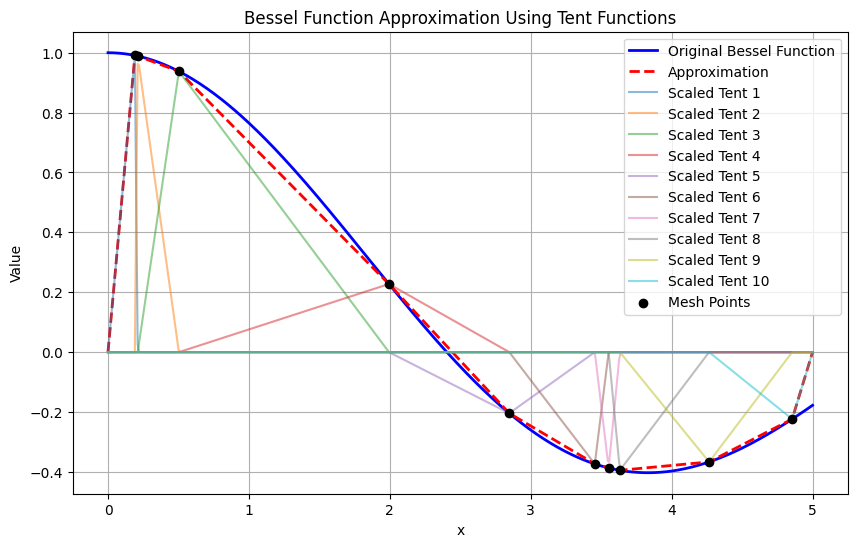

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv

# Define the Bessel function to approximate
def bessel_function(x):
    return jv(0, x)

# Define the mesh (unevenly spaced points)
mesh = np.sort(np.random.uniform(0, 5, 10))

# Define the tent (piecewise linear) basis functions
def tent_function(x, xi, x_prev, x_next):
    if x_prev <= x <= xi:
        return (x - x_prev) / (xi - x_prev)
    elif xi < x <= x_next:
        return (x_next - x) / (x_next - xi)
    else:
        return 0.0

# Evaluate the coefficients for the tent functions (sample the Bessel function at the mesh points)
coefficients = bessel_function(mesh)

# Define the range for plotting
x_vals = np.linspace(0, 5, 500)

# Compute the approximation
approximation = np.zeros_like(x_vals)
tent_functions = []

for i, xi in enumerate(mesh):
    x_prev = mesh[i - 1] if i > 0 else 0
    x_next = mesh[i + 1] if i < len(mesh) - 1 else 5
    tent_func = np.array([tent_function(x, xi, x_prev, x_next) for x in x_vals])
    tent_functions.append(tent_func)
    approximation += coefficients[i] * tent_func

# Plot the original function, the approximation, and the tent functions
plt.figure(figsize=(10, 6))
plt.plot(x_vals, bessel_function(x_vals), label='Original Bessel Function', color='blue', linewidth=2)
plt.plot(x_vals, approximation, label='Approximation', color='red', linestyle='--', linewidth=2)
for i, tent_func in enumerate(tent_functions):
    plt.plot(x_vals, coefficients[i] * tent_func, label=f'Scaled Tent {i+1}', alpha=0.5)
plt.scatter(mesh, coefficients, color='black', label='Mesh Points', zorder=5)
plt.title('Bessel Function Approximation Using Tent Functions')
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


### 2D and 3D, and other shapes

Extension to 2D and 3D is fairly straight-forward, beginning with the verticies and then refining by subdivision.

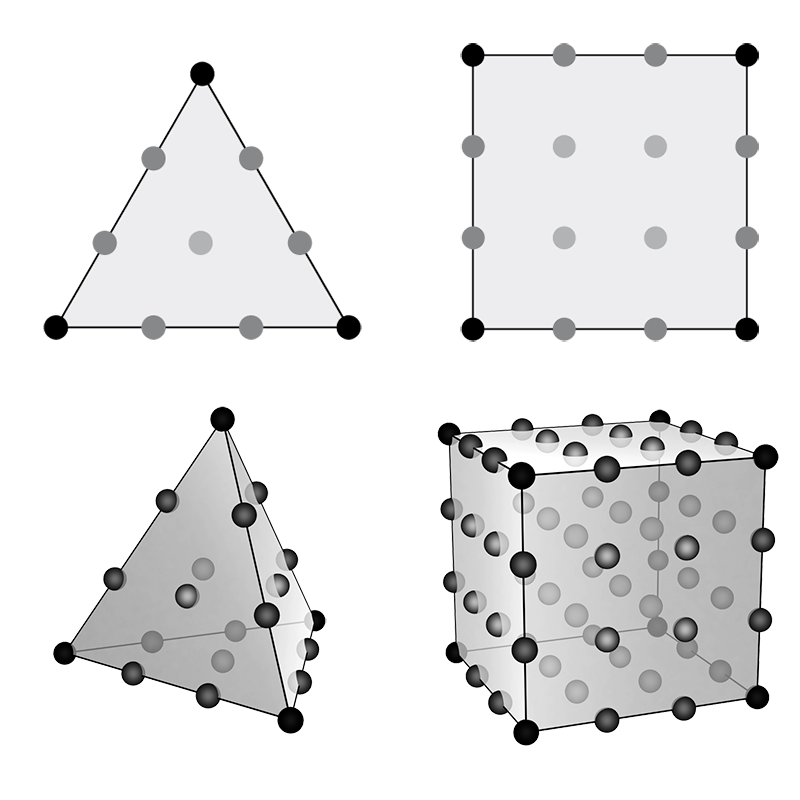

### Advanced elements

The field of Finite Elements is very rich, with elements designed specifically for certain types of physics e.g.:
* Curl of a vector field
* Divergence of a vector field
* Discontinuous elements
* Spectral Elements (very high order based on orthogonal shape functions).

A first step may be the [Periodic Table of Finite Elements](https://www-users.cse.umn.edu/~arnold/femtable/)

